# Φόρτωση Βιβλιοθηκών

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner

from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.utils import np_utils, normalize
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.initializers import RandomNormal
from tensorflow.keras.regularizers import L2
from keras.initializers import HeNormal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

# 2. Fine tuning δικτύου 

- Φόρτωση και κανονικοποίηση των δεδομένων και διαχωρισμός σε train και validation datasets

In [4]:
#load mnist dataset
(x_train, y_train), (x_test, y_test)  = mnist.load_data()

#Data normalization/scaling

x_train = normalize(x_train, axis=1)
x_test = normalize(x_test, axis=1)

#convert to binary class matrix
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

#split train data to train and validation datasets
x_train, x_val = tf.split(x_train, [int(48000), int(12000)], 0)
y_train, y_val = tf.split(y_train, [int(48000), int(12000)], 0)


- Δημιουργία συναρτήσεων που θα χρησιμοποιηθούν στη συνέχεια

In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


#Network fine tuning 

- Αρχικά δημιουργούμε ένα μοντέλο με όλες τις παραμέτρους και τις τιμές που θέλουμε να λαμβάνουν, σύμφωνα με τις διαδικασίες του keras

In [6]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(hp.Choice('n_h1', [64, 128]),
                    activation = 'relu',
                    kernel_initializer = HeNormal(),
                    kernel_regularizer = L2(hp.Choice('alpha', [0.1, 0.001, 0.000001]))))
    model.add(Dense(hp.Choice('n_h2', [256,512]),
                    activation='relu',
                    kernel_initializer = HeNormal(),
                    kernel_regularizer = L2(hp.Choice('alpha', [0.1, 0.001, 0.000001]))))
    
    model.add(Dense(10, activation='softmax')) 
    
    model.compile(optimizer = RMSprop(learning_rate = hp.Choice('lr', [0.1, 0.01, 0.001])),
                  loss = "categorical_crossentropy",
                  metrics = ['accuracy', recall_m, precision_m, f1_m])
    return model


- Στη συνέχεια χρησιμοποιώντας τον keras tuner πραγματοποιούμε το tuning του μοντέλου που ορίσαμε προηγουμένως

In [7]:
tuner = keras_tuner.RandomSearch(build_model, objective=keras_tuner.Objective("f1_m", direction='max'),overwrite = True)
           
stop_early = EarlyStopping(monitor="loss",
                           patience=200,
                           restore_best_weights=True)
tuner.search(x_train, y_train,
             epochs=1000,
             validation_split=0.2,
             callbacks=[stop_early])

Trial 10 Complete [00h 28m 11s]
f1_m: 0.9985933303833008

Best f1_m So Far: 0.9985933303833008
Total elapsed time: 03h 21m 10s
INFO:tensorflow:Oracle triggered exit


- Αφού ολοκληρωθεί το tuning, παίρνουμε τις βέλτιστες υπερπαραμέτρους του μοντέλου

In [10]:
optimal_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
n_h1 = optimal_hyperparameters.get('n_h1')
n_h2 = optimal_hyperparameters.get('n_h2')
alpha = optimal_hyperparameters.get('alpha')
lr = optimal_hyperparameters.get('lr')

print(f'Best number of neurons in the first hidden layer: ' +str(n_h1))
print(f'Best number of neurons in the second hidden layer: ' +str(n_h2))
print(f'Best value for alpha: ' +str(alpha))
print(f'Best value for learning_rate: ' +str(lr))

Best number of neurons in the first hidden layer: 64
Best number of neurons in the second hidden layer: 256
Best value for alpha: 1e-06
Best value for learning_rate: 0.001


- Τέλος, εκπαιδεύουμε το μοντέλο με τις βέλτιστες παραμέτρους που βρήκαμε

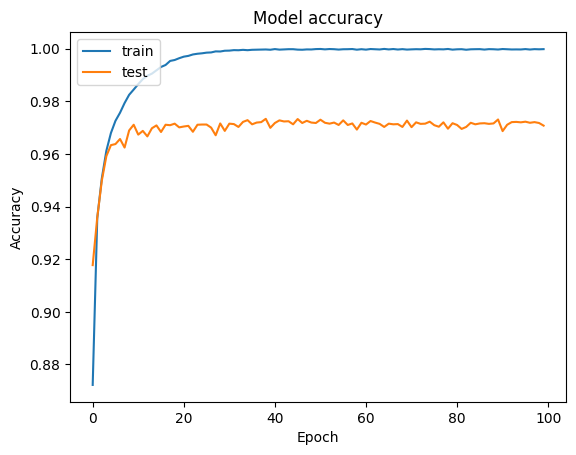

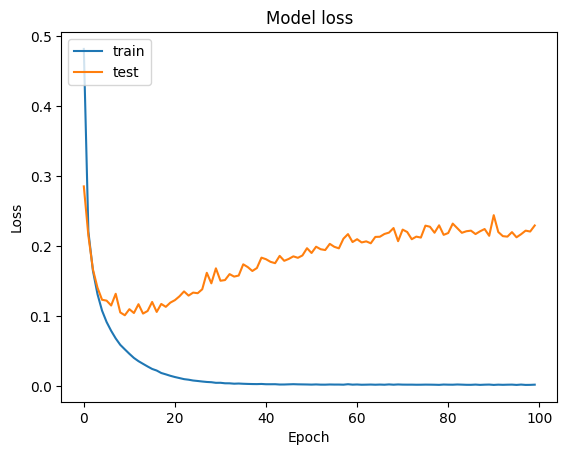

In [16]:
model = Sequential()
model.add(Flatten())
model.add(Dense(n_h1,
                activation = 'relu',
                kernel_initializer = HeNormal(),
                kernel_regularizer = L2(alpha)))
model.add(Dense(n_h2,
                activation='relu',
                kernel_initializer = HeNormal(),
                kernel_regularizer = L2(alpha)))

model.add(Dense(10, activation='softmax')) 

model.compile(optimizer = RMSprop(learning_rate = lr),
              loss = "categorical_crossentropy",
              metrics = ['accuracy', recall_m, precision_m, f1_m])

history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), verbose=0)

#Plot results

#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Και εξάγουμε τον πίνακα σύγχυσης 

In [19]:
predict = model.predict(x_test)
confusion_matrix = confusion_matrix(y_test.argmax(axis=1), predict.argmax(axis=1))
print(confusion_matrix)

313/313 [==============================] - 1s 2ms/step
[[ 969    0    0    0    0    1    1    1    3    5]
 [   0 1122    4    1    0    1    4    2    1    0]
 [   7    3  986    6    4    0    3   12   11    0]
 [   0    1    2  982    0    8    0    6    5    6]
 [   0    1    5    1  948    0    2    6    1   18]
 [   6    0    0   10    0  864    4    1    5    2]
 [   8    3    1    1    4    3  935    0    3    0]
 [   2    3    6    2    2    0    0 1007    2    4]
 [   6    1    4    6    5    2    4    7  935    4]
 [   4    3    0    6   10    1    3    3    2  977]]
